#PySpark Machine Learning

PySpark is known for its speed in machine learnin and uses multiple machines for large-scale data processing. It runs on distributed computing, such as YARN, Mesos, and Standalone clusters.

PySpark provides a flexible API that mirrors the expressiveness of scikit-learn while also harnessing the advantages of distributed computing. In this notebook, we showcase the utilization of the pyspark.ml module to create machine learning pipelines on Spark data frames on top of Spark data frames (instead of RDDs with the older pyspark.mllib module).

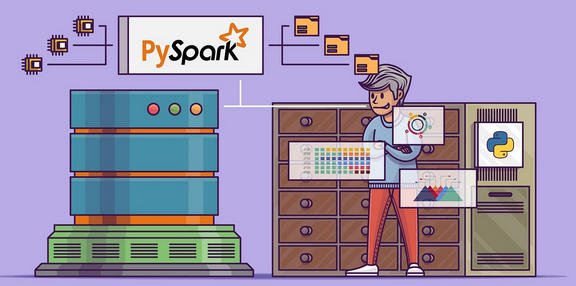

### Import necessary libraries

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=fcdf3f4a5d45dd1c14ee8317bc0f1491b2dfc08a22e9046dc74644ad512b4741
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
# Install library for finding Spark
!pip install -q findspark

In [3]:
# Import the findspark library to locate and initialize Spark
import findspark
findspark.init()

# Import necessary components from PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType
from pyspark.ml.feature import StringIndexer , OneHotEncoder,VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [4]:
#Creating Spark Session
spark = SparkSession.builder.getOrCreate()

In [94]:
# Define the schema with column names
schema = StructType([
    StructField("id", IntegerType(), True),                         # id
    StructField("name", StringType(), True),                       # name
    StructField("host_id", IntegerType(), True),                   # host_id
    StructField("host_name", StringType(), True),                  # host_name
    StructField("neighbourhood_group", StringType(), True),         # neighbourhood_group
    StructField("neighbourhood", StringType(), True),               # neighbourhood
    StructField("latitude", DoubleType(), True),                   # latitude
    StructField("longitude", DoubleType(), True),                  # longitude
    StructField("room_type", StringType(), True),                  # room_type
    StructField("price", IntegerType(), True),                     # price
    StructField("minimum_nights", IntegerType(), True),            # minimum_nights
    StructField("number_of_reviews", IntegerType(), True),         # number_of_reviews
    StructField("last_review", StringType(), True),                # last_review
    StructField("reviews_per_month", DoubleType(), True),          # reviews_per_month
    StructField("calculated_host_listings_count", IntegerType(), True),  # calculated_host_listings_count
    StructField("availability_365", IntegerType(), True),          # availability_365
    StructField("city", StringType(), True)                        # city
])

# Read the CSV file with the inferred schema
filepath = "/content/drive/MyDrive/airbnb_data.csv"
airbnb_df = spark.read.option("header", "true").schema(schema).csv(filepath)


In [63]:
#Dispaly first 10 rows
airbnb_df.show(10)

+------+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------+
|    id|                name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|     city|
+------+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------+
| 38585|Charming Victoria...| 165529|  Evelyne|               NULL|        28804|35.65146|-82.62792|   Private room|   60|             1|              138|   16/02/20|             1.14|                             1|               0|Asheville|
| 80905|    French Chic 

In [ ]:
#Descriptive Analysis
airbnb_df.describe().show()

+-------+-----------------+--------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------------------+------------------+------------------+
|summary|               id|                name|            host_id|           host_name|neighbourhood_group|     neighbourhood|          latitude|         longitude|        room_type|             price|    minimum_nights| number_of_reviews|       last_review| reviews_per_month|calculated_host_listings_count|  availability_365|              city|
+-------+-----------------+--------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------------

#### Simple Linear regression(Linear regression with one feature)

In [ ]:
#Select the feature an the target column
# In this case, we're selecting the "minimum_nights">> input and "price">> target column
airbnb_df.select(["minimum_nights","price"]).show()

+--------------+-----+
|minimum_nights|price|
+--------------+-----+
|             1|   60|
|             1|  470|
|            30|   75|
|             1|   90|
|            30|  125|
|             7|  134|
|             1|   48|
|             3|   65|
|            28|   71|
|            90|   50|
|            30|  289|
|             4|   78|
|             2|  125|
|             3|  126|
|             2|  118|
|             2|   85|
|            30|   50|
|            30|   97|
|             2|   74|
|            30|  160|
+--------------+-----+
only showing top 20 rows



In [95]:
airbnb_df = airbnb_df.dropna(subset=["price"])
airbnb_df = airbnb_df.drop("neighbourhood_group","city")

In [96]:
# Assuming your DataFrame is named 'df'
airbnb_df = airbnb_df.dropna()


In [97]:
# Split the data into training and testing sets
# We are using a random split with a 80% training and 20% testing ratio
# The seed is set to 42 for reproducibility
trainDF, testDF = airbnb_df.randomSplit([0.8, 0.2], seed=42)


In Pyspark it’s a good practice to save your train and test sets after splitting. In PySpark, even if you use a seed, the split can be different each time due to the distributed nature of the data.This is because the data is distributed across different nodes in the cluster, and the splitting process is carried out on each node independently.Therefore, even though the seed is the same, the way the data is distributed can affect the resulting split.

In [ ]:
# Define a VectorAssembler
# This step is used to assemble a vector of features
# In this case, we're using the "minimum_nights" column as the input feature
# The resulting feature vector will be stored in the "features" column
vectorAssembler = VectorAssembler(inputCols=["minimum_nights"], outputCol='features', handleInvalid="keep")

In PySpark, VectorAssembler is used to transform multiple numeric columns into a single vector column. This is often a necessary step as many machine learning algorithms in PySpark, such as Linear Regression or Logistic Regression, require input data to be in the form of a single vector column.

In [ ]:
# Transform the training data using the VectorAssembler
# This step applies the VectorAssembler to the training DataFrame (trainDF)
# The resulting feature vectors are added as a new column named "features"
vecTrainDf = vectorAssembler.transform(trainDF)
vecTrainDf.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- availability_365: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
# Display the selected columns: "minimum_nights," "price," and "features"
vecTrainDf.select(["minimum_nights","price","features"]).show(10)

+--------------+-----+--------+
|minimum_nights|price|features|
+--------------+-----+--------+
|            30|   85|  [30.0]|
|            30|   50|  [30.0]|
|             4|  249|   [4.0]|
|             3|   95|   [3.0]|
|             2|  226|   [2.0]|
|             2|  100|   [2.0]|
|             2|  189|   [2.0]|
|             2|  147|   [2.0]|
|             1|   48|   [1.0]|
|             3|   75|   [3.0]|
+--------------+-----+--------+
only showing top 10 rows



In [ ]:
# Remove rows with null or NaN values in the "price" column
vecTrainDf = vecTrainDf.dropna(subset=["price"])

In [ ]:
# Create a Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='price')


In [ ]:
#fit the model to the data
lrmodel = lr.fit(vecTrainDf)


In [ ]:
# Transform the testing data using the VectorAssembler
vecTestDf = vectorAssembler.transform(testDF)

In [ ]:
# Make predictions on the testing data using the trained Linear Regression model
predDF = lrmodel.transform(vecTestDf)


In [ ]:
# Select and display the "price" (actual) and "prediction" columns from the predictions DataFrame
predDF.select(["price", "prediction"]).show()


+-----+------------------+
|price|        prediction|
+-----+------------------+
|  102|137.27838997166012|
|   89|137.91277105655234|
|  232|137.91277105655234|
|  150|137.91277105655234|
|   75|138.54715214144454|
|   84|138.54715214144454|
|  130|137.91277105655234|
|  120|138.54715214144454|
|   92|138.54715214144454|
|  160|137.91277105655234|
|   90|120.15010067957039|
|  274|137.91277105655234|
|  514|138.54715214144454|
|  244|137.27838997166012|
|  114|138.54715214144454|
|   74|138.54715214144454|
|   97|137.91277105655234|
|  114|137.91277105655234|
|   76|138.54715214144454|
|   44|138.54715214144454|
+-----+------------------+
only showing top 20 rows



#### Pyspark pipline

In [ ]:
# initiate the pipeline
# The pipeline consists of two stages: VectorAssembler and Linear Regression
pipeline = Pipeline(stages=[vectorAssembler, lr])

# Fit the pipeline on the training data
pipeline_model=pipeline.fit(trainDF)


In [ ]:
# Make predictions on the testing data using the fitted machine learning pipeline
predDF = pipeline_model.transform(testDF)

In [ ]:
# Select and display the "price" (actual) and "prediction" columns from the predictions DataFrame
predDF.select(["price", "prediction"]).show()

+-----+------------------+
|price|        prediction|
+-----+------------------+
|  102|135.97401157552721|
|   89|136.78447321515338|
|  232|136.78447321515338|
|  150|136.78447321515338|
|   75|137.59493485477955|
|   84|137.59493485477955|
|  130|136.78447321515338|
|  120|137.59493485477955|
|   92|137.59493485477955|
|  160|136.78447321515338|
|   90|114.09154730562062|
|  274|136.78447321515338|
|  514|137.59493485477955|
|  244|135.97401157552721|
|  114|137.59493485477955|
|   74|137.59493485477955|
|   97|136.78447321515338|
|  114|136.78447321515338|
|   76|137.59493485477955|
|   44|137.59493485477955|
+-----+------------------+
only showing top 20 rows



#### Model Evaluation

In [ ]:
# Create an evaluator
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

# Calculate RMSE (Root Mean Squared Error)
rmse = evaluator.evaluate(predDF)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 125.533


#### Multiple linear regression (MLR)

In [89]:
# Identify categorical columns in the training DataFrame
# This code selects columns where the data type is 'string'
categoricalCols = [f for (f, dt) in trainDF.dtypes if dt == 'string']

# Display the list of identified categorical columns
categoricalCols


['name', 'host_name', 'neighbourhood', 'room_type', 'last_review']

In [91]:
# Identify numeric columns in the training DataFrame
# This code selects columns where the data type is 'double' or 'integer' (excluding 'price')
numericCol = [f for (f, dt) in trainDF.dtypes if ((dt == 'double' or dt == 'int') and (f != 'price'))]
numericCol

['id',
 'host_id',
 'latitude',
 'longitude',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

**Important Note :** In PySpark, when dealing with categorical columns, you should use the `StringIndexer` first and then apply `OneHotEncoder`.

The `StringIndexer` will convert the categorical string values into numerical label indices. For instance, if you have a column 'color' with values 'red', 'green', and 'blue', `StringIndexer` might convert this to a numerical feature with values 0, 1, and 2 respectively.

After that, you can apply `OneHotEncoder` to these label indices. The `OneHotEncoder` will map these label indices to a binary vector with at most a single one-value indicating the presence of a specific feature value from among the set of all feature values.

This process is necessary because most machine learning algorithms work better with numerical input and output. Converting categorical string data into numerical data allows these algorithms to make better use of the information.

In [114]:
# Create StringIndexers for categorical columns
stringIndexers = [StringIndexer(inputCol=col, outputCol=col + "_index",handleInvalid="keep") for col in categoricalCols]

In [115]:
# Create OneHotEncoders for indexed categorical columns
oneHotEncoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_OHE") for col in categoricalCols]

In [116]:
# Create a VectorAssembler to assemble features
assemblerInputCols = [col + "_OHE" for col in categoricalCols] + numericCol
vectorAssembler = VectorAssembler(inputCols=assemblerInputCols, outputCol='features',handleInvalid='keep')

In [117]:
# Create a LinearRegression estimator
lr = LinearRegression(featuresCol='features', labelCol='price')

In [118]:
# Define the stages for the pipeline
stages = stringIndexers + oneHotEncoders + [vectorAssembler, lr]

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Fit the pipeline on the training data
pipelineModel = pipeline.fit(trainDF)

In [119]:
## Make predictions on the testing data using the fitted machine learning pipeline
predDf = pipelineModel.transform(testDF)

In [120]:
predDf.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- availability_365: integer (nullable = true)
 |-- name_index: double (nullable = false)
 |-- host_name_index: double (nullable = false)
 |-- neighbourhood_index: double (nullable = false)
 |-- room_type_index: double (nullable = false)
 |-- last_review_index: double (nullable = false)
 |-- name_OHE: vector (nullable = true)
 |-- host_name_OHE: vector (nullable = true)
 |-- neighb

In [122]:
predDf.select('host_name','host_name_index','host_name_OHE').show()

+----------------+---------------+-----------------+
|       host_name|host_name_index|    host_name_OHE|
+----------------+---------------+-----------------+
|            Lisa|           11.0| (495,[11],[1.0])|
|         Susanne|          495.0|      (495,[],[])|
|           Julia|          495.0|      (495,[],[])|
|           Heidi|          287.0|(495,[287],[1.0])|
|           Molly|          495.0|      (495,[],[])|
|        Michelle|           31.0| (495,[31],[1.0])|
|            Bart|          495.0|      (495,[],[])|
|           Terri|          495.0|      (495,[],[])|
|          Brenda|          495.0|      (495,[],[])|
|         Celeste|            4.0|  (495,[4],[1.0])|
|         Celeste|            4.0|  (495,[4],[1.0])|
|           Linda|          128.0|(495,[128],[1.0])|
|            Theo|          495.0|      (495,[],[])|
|         Sivanne|          495.0|      (495,[],[])|
|Louise And Steve|          371.0|(495,[371],[1.0])|
|          Lauren|          495.0|      (495,[

The representation `(495,[],[])` in the host_name_OHE column indicates a Sparse Vector format. In this format, the first number `(495)` represents the total number of elements in the vector, the second part (an empty array `[]`) represents the indices of non-zero elements in the vector, and the third part (another empty array `[]`) represents the values of those non-zero elements.

In your example, `(495,[],[])` means that the one-hot encoded vector for the host_name feature has 495 elements, and all of them are zero except for the index 495, which has a non-zero value of 1.0.

In [124]:
predDf.select('features','price','prediction').show()

+--------------------+-----+------------------+
|            features|price|        prediction|
+--------------------+-----+------------------+
|(1543,[834,1319,1...|   75|176.85203702226954|
|(1543,[1318,1327,...|   48|108.58649392412599|
|(1543,[1322,1326,...|   71| 94.84268070604958|
|(1543,[1110,1319,...|  126| 208.2074298284756|
|(1543,[1319,1326,...|  160|127.16780764345049|
|(1543,[854,1319,1...|   52| 45.71719153572258|
|(1543,[1321,1326,...|  183| 153.7831668463441|
|(1543,[1319,1326,...|  257|159.83386710889363|
|(1543,[1319,1327,...|   95| 99.75010716778206|
|(1543,[827,1319,1...|  514| 290.9289750445928|
|(1543,[827,1319,1...|  273|  269.548336544171|
|(1543,[951,1322,1...|   57|153.97566939330682|
|(1543,[1321,1326,...|  202|197.24838926581515|
|(1543,[1318,1327,...|   85|103.59798640099734|
|(1543,[1194,1322,...|  325|234.96034510759046|
|(1543,[1319,1326,...|   60|194.16253475525946|
|(1543,[1318,1327,...|   65|106.00367093723298|
|(1543,[908,1319,1...|  239|139.81083009

In [126]:
# Create an evaluator
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

# Calculate RMSE (Root Mean Squared Error)
rmse = evaluator.evaluate(predDf)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 114.614


In [128]:
# Create an evaluator
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")

# Calculate R-Squared
r2 = evaluator.evaluate(predDf)
print("The R-Squared on test data = %g" % r2)

The R-Squared on test data = 0.154322


The R-squared value of 0.154322 for a model indicates that it explains only a small portion of the variance in the target variable. In other words, the model's predictions do not fit the test data well, as it can only explain about 15.43% of the variability in the test data.

Whether this R-squared value is considered "good" depends on the context and the specific problem you are trying to solve. In many cases, an R-squared value of 0.15 would be considered relatively low, suggesting that there may be room for improvement in the model's predictive power.

In [129]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Create a Random Forest Regressor
rf = RandomForestRegressor(featuresCol='features', labelCol='price')

# Define the stages for the pipeline
stages = stringIndexers + oneHotEncoders + [vectorAssembler, rf]

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Fit the pipeline on the training data
pipelineModel = pipeline.fit(trainDF)

# Make predictions on the testing data
predDf = pipelineModel.transform(testDF)

# Evaluate the model using RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predDf)
rmse = evaluator.evaluate(predDf, {evaluator.metricName: "rmse"})

print(f"R-squared value: {r2}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


R-squared value: 0.058597540778682955
Root Mean Squared Error (RMSE): 120.9272019527857


# Conclusion

In conclusion, this notebook serves as an educational resource for learning how to use PySpark for machine learning tasks.
The primary objective of this notebook was not to attain a high R-squared (R2) score, but rather to help you gain a deeper understanding of PySpark's capabilities and best practices in a learning environment. Real-world machine learning projects often involve extensive experimentation and fine-tuning to optimize model performance, which was beyond the scope of this educational exercise.
